In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from dataclasses import dataclass

In [21]:
def load_data() -> pd.DataFrame:
    """
    Loads mnist_784 dataset from the sklearn.datasets

    Returns:
        pd.DataFrame: The minst dataset in dataframe format
    """

    df_ujjwal = fetch_openml('mnist_784', version=1, as_frame=True, parser='auto')

    # .frame converts the data into pandas readable frame
    return df_ujjwal.frame

df_ujjwal = load_data()


In [22]:
# Wanted to check the type of values in each set
print(df_ujjwal.dtypes)

# It seems that the class is of different type and not int64

pixel1         int64
pixel2         int64
pixel3         int64
pixel4         int64
pixel5         int64
              ...   
pixel781       int64
pixel782       int64
pixel783       int64
pixel784       int64
class       category
Length: 785, dtype: object


In [24]:
def split_data() -> pd.DataFrame:
    """
    Splits the data into features and labels
    Also, converts the type of class from category to int64
    """

    # Splitting the data into features and class
    X = df_ujjwal.drop('class', axis=1)
    y = df_ujjwal['class']

    # To convert the category type to Int64
    y = y.astype(int)

    return X, y

X, y = split_data()

# Shape of X and y
print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Type of X and y
print(f"\nType of X: {X.dtypes}")
print(f"Type of y: {y.dtypes}")


Shape of X: (70000, 784)
Shape of y: (70000,)

Type of X: pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
pixel5      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 784, dtype: object
Type of y: int64


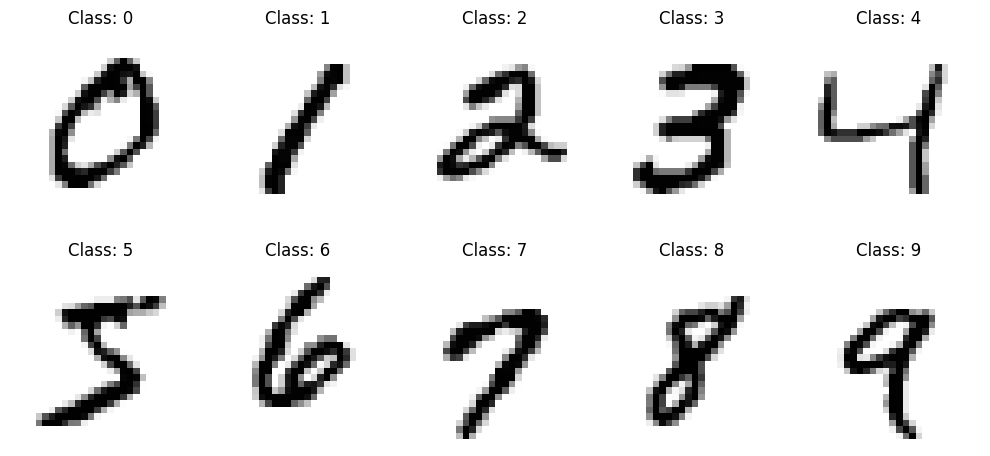

In [ ]:
def plot_digit_grid(X_df: pd.DataFrame, y: pd.DataFrame):
    """
    Plots a 2x5 grid of sample MNIST digits for each class from 0-9.

    Args:
    X_df (pd.DataFrame) : pandas.DataFrame
        A DataFrame where each row is a flattened 784-pixel image.
    y (pd.series) : pandas.Series
        A Series containing the corresponding integer or string labels.
    """

    # Creating the 2x5 grid for plotting (according to instruction)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))

    # Looping through each digit from 0 to 9
    for i in range(10):
        # Finding the location of the first image for the current digit
        try:
            index = y[y == i].index[0]
        except IndexError:
            # This handles cases where a digit might be missing from the data
            print(f"Warning: No sample found for digit {i}.")
            continue
        
        # Getting the pixel data, converting to NumPy array, and reshaping to 28x28
        image_data = X_df.loc[index].values.reshape(28, 28)
        
        # Calculating the subplot's position in the grid
        row, col = divmod(i, 5)
        ax = axes[row, col]
        
        # Displaying the image
        ax.imshow(image_data, cmap='binary')
        ax.set_title(f"Class: {i}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_digit_grid(X, y)

In [ ]:
# Before applying PCA, scaling data is crucial, so I will scale the data first
def scale_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    This function will use standard scaler to scale data,
    before applying the PCA

    Args:
        X: The dataframe containing the features that needs to be scaled

    Returns:
        X_scaled: Scaled dataframe
    """
    scaler = StandardScaler()

    return scaler.fit_transform(X)

X_scaled = scale_data(X)

In [47]:
@dataclass
class PCAResult:
    transformed_data: pd.DataFrame
    explained_variance: np.ndarray
    pca_model: PCA

In [ ]:
def apply_PCA(X_scaled: pd.DataFrame, components: float) -> PCAResult:
    """
    Applies PCA to the scaled dataframe

    Args:
        X_scaled: Scaled dataframe
        components: number of components for PCA

    Returns:
        transformed_data: Transformed data converted into pandas dataframe
        total_variance: An array of variance for each PCA
    """

    # Initilizing the PCA
    pca = PCA(n_components=components)

    # Applying fit_transform to the X_scaled data
    transformed_data = pca.fit_transform(X_scaled)

    # Explained variance (It is the ratio per component)
    explained_variance = pca.explained_variance_ratio_
    
    # Let's create column names for easy visualization in pandas dataframe
    col_names = [f'PC{i+1}' for i in range(components)]

    # Returning the dataframe
    return PCAResult(transformed_data=pd.DataFrame(data=transformed_data, columns=col_names), explained_variance=explained_variance, pca_model=pca)

# Time to apply PCA now
pca = apply_PCA(X_scaled, 2)

# Displaying the top 5 data after applying pca and total variance
print(pca.transformed_data.head(5))
print(f"\nTotal explained variance is {np.sum(pca.explained_variance): .2%}.")

# Displaying the explained variance ration for each component
print("\nExplained variance ratio for each components")
print(f"Explained variance ratio for PCA1: {pca.explained_variance[0]: .2%}")
print(f"Explained variance ratio for PCA2: {pca.explained_variance[1]: .2%}")


        PC1       PC2
0 -0.891720 -4.929711
1  8.813530 -7.517560
2  2.204835  9.824461
3 -6.534627 -4.029669
4 -5.251618  3.278848

Total explained variance is  9.68%.

Explained variance ratio for each components
Explained variance ratio for PCA1:  5.64%
Explained variance ratio for PCA2:  4.04%


In [ ]:
def visualize_pca():
    """
    Viaualizes the 2D projection using 1st and 2nd PCA
    """
    # First adding the label
    df_new = pca.transformed_data
    df_new['label'] = y.values

    # Let's take random sample for clearer plot
    df_sample = pca.transformed_data.sample(n=15000, random_state=42)

    # Creating the scatterplot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df_sample,
        x='PC1',
        y='PC2',
        hue='label',
        palette=sns.color_palette("tab10", 10),
        s=20, # Marker size
        alpha=0.6, # Marker transparency
        legend='full'
    )

    plt.title('2D Projection of MNIST Dataset using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Digit')
    plt.grid(True)
    plt.show()

visualize_pca()

In [ ]:
@dataclass
class IncrementalPCAResult:
    reduced_data: pd.DataFrame
    reconstructed_data: np.ndarray
    explained_variance: np.ndarray
    pca_model: IncrementalPCA

In [ ]:
def apply_incremental_pca(X_scaled: pd.DataFrame, n_components: float, batch_size: int) -> IncrementalPCAResult:
    """
    Applies IncrementalPCA in batches to the scaled data.

    Args:
        X_scaled (pd.DataFrame): Scaled numpy array of the data.
        n_components (float): Number of components for PCA.
        batch_size (int): The number of samples to use for each batch.

    Returns:
        A NamedTuple containing the reduced data (DataFrame), 
        reconstructed data (NumPy array), explained variance, and the fitted model.
    """

    # Initilizing the incremental PCA
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

    # Fitting the model in batches for efficiency
    # array_split is one of the best way to split it
    for batch in np.array_split(X_scaled, len(X_scaled) // batch_size):
        inc_pca.partial_fit(batch)

    # Let's transform the entire dataset to the reduced space
    X_reduced = inc_pca.transform(X_scaled)

    # Performing the inverse transform to get reconstructed data
    X_reconstructed = inc_pca.inverse_transform(X_reduced)

    # Explained variance
    explained_variance = inc_pca.explained_variance_ratio_

    # Columns names for the dataframe
    col_names = [f'PC{i+1}' for i in range(n_components)]

    # Returning the result in tuple
    return IncrementalPCAResult(reduced_data=pd.DataFrame(data=X_reduced, columns=col_names), reconstructed_data=X_reconstructed, explained_variance=explained_variance, pca_model=inc_pca)


In [ ]:
pca_results = apply_incremental_pca(X_scaled, n_components=154, batch_size=5000)

# Displaying the top 5 data after applying incremental pca and total variance
print(pca_results.reduced_data.head(5))
print(f"\nTotal explained variance is {np.sum(pca_results.explained_variance): .2%}.")

# Displaying the explained variance ration for each component
print("\nExplained variance ratio for each components")
print(pca_results.explained_variance)

# Displaying the shapes of reduced_data and reconstructed_data
print(f"\nShape of reduced data: {pca_results.reduced_data.shape}")
print(f"Shape of reconstructed data: {np.shape(pca_results.reconstructed_data)}")

In [ ]:
def display_original_reconstructed(X: pd.DataFrame, X_reconstructed: np.ndarray, y: np.ndarray):
    """ 
    Displays the original digits and reconstructed images

    Args:
        X (pd.DataFrame): An original dataframe (not transformed)
        X_reconstructed (np.ndarray): A dataset that is reconstructed after applying PCA
        y (np.ndarray): An array of labels
    """
    # Setting up the plot grid (5 rows, 2 columns)
    fig, axes = plt.subplots(5, 2, figsize=(8, 12))
    fig.suptitle('Original vs. Reconstructed Images', fontsize=16)

    # Choosing random 5 image to display
    sample_indices = np.random.choice(X.index, 5)

    # Looping through the sample and plotting them
    for i, index in enumerate(sample_indices):
        # Plot for Original Image (Left Column) ---
        ax_orig = axes[i, 0]
        original_image = X.loc[index].values.reshape(28, 28)
        ax_orig.imshow(original_image, cmap='binary')
        ax_orig.set_title(f'Original: {y.loc[index]}')
        ax_orig.axis('off')

        # Plot for Reconstructed Image (Right Column) ---
        ax_recon = axes[i, 1]
        reconstructed_image = X_reconstructed[index].reshape(28, 28)
        ax_recon.imshow(reconstructed_image, cmap='binary')
        ax_recon.set_title(f'Reconstructed: {y.loc[index]}')
        ax_recon.axis('off')

In [ ]:
display_original_reconstructed(X=X, X_reconstructed=pca_results.reconstructed_data, y=y)